In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_excel('./data/ToyotaCorolla.xls', sheet_name='data')
df = raw_df.copy()
df.drop(['Id', 'Model'], axis = 1, inplace=True) 
print(df.info())

# Encoding non-numeric features 
one_hot_encodingpd = pd.get_dummies(list(set(raw_df.Fuel_Type)))
df['Fuel_Type'] = df.apply(axis=1, func=lambda x: int("".join(map(str, one_hot_encodingpd[x['Fuel_Type']])), 2))
one_hot_encodingpd = pd.get_dummies(list(set(raw_df.Color)))
df['Color'] = df.apply(axis=1, func=lambda x: int("".join(map(str, one_hot_encodingpd[x['Color']])), 2))

def normalize(x):
    mean = x.mean()
    var = x.std()
    if var != 0.0:
        return (x - mean) / var
    else:
        return x

# Rescale df columns to the range 0-1
df = df.apply(lambda x: normalize(x))



# Divide dataset into 70%, 15% and another %15 for train, validation and test. 
train_df = df.sample(frac=0.70)
validation_df = df.drop(train_df.index).sample(frac=0.5)
test_df = df.drop(train_df.index).drop(validation_df.index)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Price              1436 non-null   int64 
 1   Age_08_04          1436 non-null   int64 
 2   Mfg_Month          1436 non-null   int64 
 3   Mfg_Year           1436 non-null   int64 
 4   KM                 1436 non-null   int64 
 5   Fuel_Type          1436 non-null   object
 6   HP                 1436 non-null   int64 
 7   Met_Color          1436 non-null   int64 
 8   Color              1436 non-null   object
 9   Automatic          1436 non-null   int64 
 10  CC                 1436 non-null   int64 
 11  Doors              1436 non-null   int64 
 12  Cylinders          1436 non-null   int64 
 13  Gears              1436 non-null   int64 
 14  Quarterly_Tax      1436 non-null   int64 
 15  Weight             1436 non-null   int64 
 16  Mfr_Guarantee      1436 non-null   int64 


In [1]:
# SGD Regression  
class SGDRegression() : 
      
    def __init__(self, norm=2, learning_rate=0.001, iterations=1000, l2_penality=0) : 
          
        self.learning_rate = learning_rate         
        self.iterations = iterations         
        self.l2_penality = l2_penality 
        
        self.update_weights = self.norm2_update_weights
        if norm == 1:
            self.update_weights = self.norm1_update_weights
        self.norm = norm

          
    # Estimate linear regression w* using Stochastic Gradient Descent 
    def train(self, train_df) : 
        self.X = np.array(train_df.drop('Price', axis=1))        
        self.Y = np.array(train_df['Price']) 
        
        # no_of_training_examples, no_of_features         
        self.n, self.m = self.X.shape 
          
        # weight initialization         
        self.w = np.zeros(self.m) 
        self.b = 0    
        self.all_w = []
        
             
        # gradient descent learning 
                  
        for i in range(self.iterations) :             
            self.update_weights()             
        return self
    
    
    # Calculate gradient of MSE loss function w.r.t w 
    def norm2_update_weights(self):
        y_pred = self.predict(self.X)

        dw = (- 2 * (self.X.T).dot(self.Y - y_pred) + 
                  2 * self.l2_penality * self.w) / self.n     
        db = - 2 * np.sum(self.Y - y_pred) / self.n 
        
        # update weights     
        self.w = self.w - self.learning_rate * dw     
        self.b = self.b - self.learning_rate * db  
        
        self.all_w.append(np.concatenate((np.array([self.b]), self.w), axis=0))
        
        return self
    
    # Calculate gradient of  ||Y − Xω||1  loss function w.r.t w        
    def norm1_update_weights(self):
        y_pred = self.predict(self.X)

        dw = (- (self.X.T).dot(np.sign(self.Y - y_pred)) + 
                  2 * self.l2_penality * self.w) / self.n     
        db = - np.sum(np.sign(self.Y - y_pred)) / self.n 
        
        # update weights     
        self.w = self.w - self.learning_rate * dw     
        self.b = self.b - self.learning_rate * db  
        
        self.all_w.append(np.concatenate((np.array([self.b]), self.w), axis=0))
        
        return self
    
    def predict(self, X) :     
        return X.dot(self.w) + self.b 

In [2]:
# Make a prediction with w
def predict(X, w, b) :     
        return X.dot(w) + b 
    
def mean_squared_error(y_hat, y):
    sum_of_squer_error = 0
    n = len(y)
    for i in range(n):
        sum_of_squer_error += (y[i] - y_hat[i])**2
    return sum_of_squer_error / n

def norm_1_error(y_hat, y):
    error = 0
    n = len(y)
    for i in range(n):
        error += abs(y[i] - y_hat[i])
    return error / n

def calculate_error_per_iter_for_dataset(df, all_w, error_func=mean_squared_error):
    x_df = df.drop('Price', axis=1)
    x = np.array(x_df)
    y = np.array(df['Price'])
    
    error = []
    for iteration in range(len(all_w)):
        predictions = predict(x, all_w[iteration][1:], all_w[iteration][0])
        error.append(error_func(np.array(predictions), y))
        
    return error

   

def train_SGD_regression(train_df, validation_df, norm, λ=0):
    learning_rate = 0.1
    min_mse_for_validation = 1000
    all_W_star = []
    for i in range(100):
        sgd_regressor = SGDRegression(norm=norm, learning_rate=learning_rate, iterations=100, l2_penality=λ)
        sgd_regressor.train(train_df=train_df)
        all_w = sgd_regressor.all_w
        validation_MSE = calculate_error_per_iter_for_dataset(validation_df, [all_w[-1]])[-1]
        if validation_MSE < min_mse_for_validation:
            min_mse_for_validation = validation_MSE
            all_W_star = all_w
        learning_rate -= 0.001
    return all_W_star

In [ ]:
simple_regressor_using_SGD_all_w = train_SGD_regression(train_df, validation_df, norm=2)
validation_MSE1 = calculate_error_per_iter_for_dataset(validation_df, simple_regressor_using_SGD_all_w)
test_MSE1 = calculate_error_per_iter_for_dataset(test_df, simple_regressor_using_SGD_all_w)

print("Result for Q1: train a simple regressor using SGD ")

plt.scatter([i for i in range(len(simple_regressor_using_SGD_all_w))], validation_MSE1)
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.title('MSE per iteration for validation dataset')
plt.show()

plt.scatter([i for i in range(len(simple_regressor_using_SGD_all_w))], test_MSE1)
plt.xlabel('Iterations')
plt.ylabel('Test MSE')
plt.title('MSE per iteration for test dataset')
plt.show()

print('Mean Squared Error for test dataset:', test_MSE1[-1])




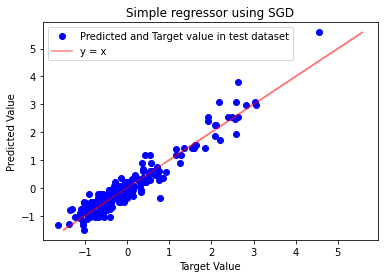

In [5]:
predictions = test_df.drop('Price', axis=1).apply(axis=1, 
                                                  func=lambda x: predict(x,
                                                                         simple_regressor_using_SGD_all_w[-1][1:], 
                                                                         simple_regressor_using_SGD_all_w[-1][0]))
real_Y = test_df['Price']


plt.figure()
plt.plot(predictions, real_Y, 'bo', label='Predicted and Target value in test dataset')
plt.plot(real_Y, real_Y, 'r-', label='y = x', alpha=0.5)
plt.ylabel('Predicted Value')
plt.xlabel('Target Value')
plt.legend();
plt.title('Simple regressor using SGD')
plt.show()

In [6]:
def ridge_regression(train_df, λ=1):
    X = np.array(train_df.drop('Price', axis=1))
    y = np.array(train_df['Price'])
    
    n, m = X.shape
    phi = np.concatenate((np.array([np.ones(n)]).T, X), axis=1)    
    m += 1
    I = np.identity(m)
    
    w_star = np.dot(np.dot(np.linalg.inv(np.dot(phi.T, phi) + λ * I), phi.T), y)
    return w_star

In [7]:
ridge_regressor_all_w = train_SGD_regression(train_df, validation_df, norm=2, λ=1)
validation_MSE2 = calculate_error_per_iter_for_dataset(validation_df, [ridge_regressor_all_w[-1]])[-1]
test_MSE2 = calculate_error_per_iter_for_dataset(test_df, [ridge_regressor_all_w[-1]])[-1]

print("Result for Q2:")
print(" - Train a ridge regressor (λ = 1) using SGD:")
print('    Mean Squared Error for validation dataset:', validation_MSE2)
print('    Mean Squared Error for test dataset:', test_MSE2)
print()
print(" - Train a ridge regressor (λ = 1) using closed from solution for ridge regression (w∗ = (XTX + λI)−1XTy):")

ridge_regressor_w_star = ridge_regression(train_df, 1)
ridge_regression_validation_MSE = calculate_error_per_iter_for_dataset(validation_df, [ridge_regressor_w_star])[-1]
ridge_regression_test_MSE = calculate_error_per_iter_for_dataset(test_df, [ridge_regressor_w_star])[-1]

print('    Mean Squared Error for validation dataset:', ridge_regression_validation_MSE)
print('    Mean Squared Error for test dataset:', ridge_regression_test_MSE)

Result for Q2:
 - Train a ridge regressor (λ = 1) using SGD:
    Mean Squared Error for validation dataset: 0.09229417898645748
    Mean Squared Error for test dataset: 0.09195312277418442

 - Train a ridge regressor (λ = 1) using closed from solution for ridge regression (w∗ = (XTX + λI)−1XTy):
    Mean Squared Error for validation dataset: 0.09404920957362553
    Mean Squared Error for test dataset: 0.09282015935886964


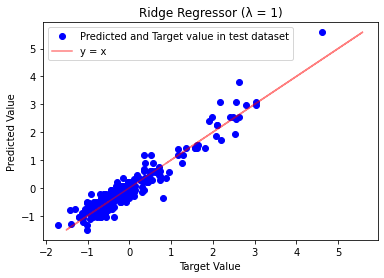

In [8]:
predictions = test_df.drop('Price', axis=1).apply(axis=1, 
                                                  func=lambda x: predict(x,
                                                                         ridge_regressor_w_star[1:], 
                                                                         ridge_regressor_w_star[0]))
real_Y = test_df['Price']


plt.figure()
plt.plot(predictions, real_Y, 'bo', label='Predicted and Target value in test dataset')
plt.plot(real_Y, real_Y, 'r-', label='y = x', alpha=0.5)
plt.ylabel('Predicted Value')
plt.xlabel('Target Value')
plt.legend();
plt.title('Ridge Regressor (λ = 1)')
plt.show()

Result for Q3: train a L1 norm regressor using SGD 
 - MSE error:


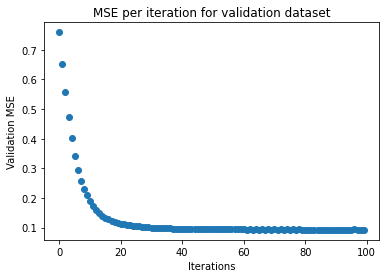

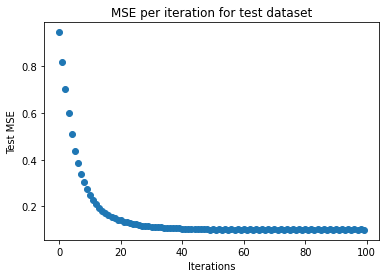

    Mean Squared Error for test dataset: 0.10083529589594038

 - L1 norm error:


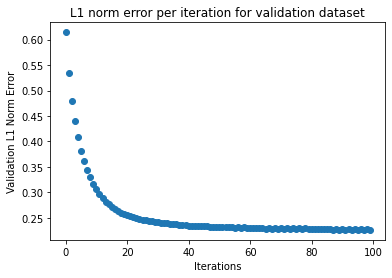

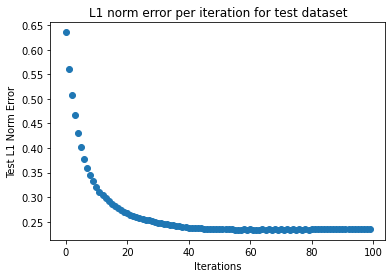

    L1 norm error for test dataset: 0.2349778677593287


In [9]:
l1_norm_regressor_using_SGD_all_w = train_SGD_regression(train_df, validation_df, norm=1)
validation_MSE3 = calculate_error_per_iter_for_dataset(validation_df, l1_norm_regressor_using_SGD_all_w)
test_MSE3 = calculate_error_per_iter_for_dataset(test_df, l1_norm_regressor_using_SGD_all_w)

print("Result for Q3: train a L1 norm regressor using SGD ")

print(" - MSE error:")

plt.scatter([i for i in range(len(l1_norm_regressor_using_SGD_all_w))], validation_MSE3)
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.title('MSE per iteration for validation dataset')
plt.show()

plt.scatter([i for i in range(len(l1_norm_regressor_using_SGD_all_w))], test_MSE3)
plt.xlabel('Iterations')
plt.ylabel('Test MSE')
plt.title('MSE per iteration for test dataset')
plt.show()

print('    Mean Squared Error for test dataset:', test_MSE3[-1])
print()


validation_l1_norm_error = calculate_error_per_iter_for_dataset(validation_df, l1_norm_regressor_using_SGD_all_w, 
                                                                error_func=norm_1_error)
test_l1_norm_error = calculate_error_per_iter_for_dataset(test_df, l1_norm_regressor_using_SGD_all_w, 
                                                          error_func=norm_1_error)

print(" - L1 norm error:")

plt.scatter([i for i in range(len(l1_norm_regressor_using_SGD_all_w))], validation_l1_norm_error)
plt.xlabel('Iterations')
plt.ylabel('Validation L1 Norm Error')
plt.title('L1 norm error per iteration for validation dataset')
plt.show()

plt.scatter([i for i in range(len(l1_norm_regressor_using_SGD_all_w))], test_l1_norm_error)
plt.xlabel('Iterations')
plt.ylabel('Test L1 Norm Error')
plt.title('L1 norm error per iteration for test dataset')
plt.show()

print('    L1 norm error for test dataset:', test_l1_norm_error[-1])

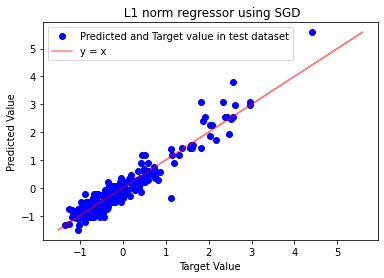

In [10]:
predictions = test_df.drop('Price', axis=1).apply(axis=1, 
                                                  func=lambda x: predict(x,
                                                                         l1_norm_regressor_using_SGD_all_w[-1][1:], 
                                                                         l1_norm_regressor_using_SGD_all_w[-1][0]))
real_Y = test_df['Price']


plt.figure()
plt.plot(predictions, real_Y, 'bo', label='Predicted and Target value in test dataset')
plt.plot(real_Y, real_Y, 'r-', label='y = x', alpha=0.5)
plt.ylabel('Predicted Value')
plt.xlabel('Target Value')
plt.legend();
plt.title(' L1 norm regressor using SGD')
plt.show()

In [20]:
print("Result for Q4: Compare regressors of part 1 and 3 by investigating weights of the model:")

simple_regressor_using_SGD_w_star = simple_regressor_using_SGD_all_w[-1]
l1_norm_regressor_using_SGD_w_star = l1_norm_regressor_using_SGD_all_w[-1]

print(" weights of model part 1:")
print(simple_regressor_using_SGD_w_star)
print()
print(" weights of model part 3:")
print(l1_norm_regressor_using_SGD_w_star)
print()

difference = np.sum(simple_regressor_using_SGD_w_star - l1_norm_regressor_using_SGD_w_star)
if difference > 0:
    print(" Weights of model part 1 are greater than weights of model part 3.")
    print("  The total difference is:", difference)
print()

train_MSE1 = calculate_error_per_iter_for_dataset(train_df, [simple_regressor_using_SGD_w_star])
train_MSE3 = calculate_error_per_iter_for_dataset(train_df, [l1_norm_regressor_using_SGD_w_star])

print(' Mean Squared Error for train dataset:')
print('  - with model part 1 :', train_MSE1[-1])
print('  - with model part 3 :', train_MSE3[-1])
print(' Mean Squared Error for validation dataset:')
print('  - with model part 1 :', validation_MSE1[-1])
print('  - with model part 3 :', validation_MSE3[-1])
print(' Mean Squared Error for test dataset:')
print('  - with model part 1 :', test_MSE1[-1])
print('  - with model part 3 :', test_MSE3[-1])
print()

if validation_MSE3[-1] < validation_MSE1[-1] and test_MSE3[-1] < test_MSE1[-1]:
    print(' It seems that model part 3, gradient of ||Y −Xω||1, works better for validation and test dataset.')
    if train_MSE1[-1] < train_MSE3[-1]:
        print(' and model part 1 have smaller MSE on train dataset. model 1 fits more on train data, compared to model 3.')        
elif validation_MSE1[-1] < validation_MSE3[-1] and test_MSE1[-1] < test_MSE3[-1]:
    print(' It seems that model part 1, gradient of MSE, works better for validation and test dataset.')
    if train_MSE1[-1] < train_MSE3[-1]:
        print(' and model part 3 have smaller MSE on train dataset. model 3 fits more on train data, compared to model 1.')

Result for Q4: Compare regressors of part 1 and 3 by investigating weights of the model:
 weights of model part 1:
[-1.94403559e-04 -2.89598350e-01 -2.65071608e-02  2.96150854e-01
 -1.89796740e-01  1.03278354e-01  6.98086027e-02 -6.83366401e-03
 -7.84710323e-03  2.37832191e-02 -9.75044332e-03  4.07125089e-03
 -7.77614237e-04  8.63002457e-03  1.38624496e-01  1.78166715e-01
  3.17701188e-02  3.64831765e-02  6.95782800e-02 -3.48866374e-02
  6.55387081e-04  2.37699620e-03  3.33949464e-02  1.55208473e-01
 -2.77120433e-02  3.06466113e-02 -3.68875819e-03  5.31554697e-02
 -1.13192565e-03  5.40669042e-03 -7.26650726e-03  3.17168310e-02
 -2.49924438e-02  1.83401860e-02 -1.77118337e-02 -1.33210758e-02
 -2.05966439e-02]

 weights of model part 3:
[-1.07462687e-04 -2.70468458e-01 -3.24863330e-02  2.77990475e-01
 -1.86267475e-01  7.73414054e-02  2.64477033e-02 -1.54389672e-02
  3.18985719e-03  2.78939125e-02 -4.86512831e-03  4.34660144e-03
 -4.29850746e-04  1.34115479e-02  8.46499662e-02  1.95632350

In [19]:
print("Result for Q4: seting λ to zero")
print(" Train a ridge regressor (λ = 0) using closed from solution for ordinary linear regression \
(w∗ = (XTX)−1XTy):")

ridge_regressor_w_star_lambda0 = ridge_regression(train_df, 0)
ridge_regression_lambda0_validation_MSE = calculate_error_per_iter_for_dataset(validation_df, 
                                                                               [ridge_regressor_w_star_lambda0])[-1]
ridge_regression_lambda0_test_MSE = calculate_error_per_iter_for_dataset(test_df, [ridge_regressor_w_star_lambda0])[-1]

print(' - Mean Squared Error for validation dataset:', ridge_regression_lambda0_validation_MSE)
print('    with λ = 1, the MSE for validation set is:', ridge_regression_validation_MSE)
print()
print(' - Mean Squared Error for test dataset:', ridge_regression_lambda0_test_MSE)
print('    with λ = 1, the MSE for test set is:', ridge_regression_test_MSE)


Result for Q4: seting λ to zero
 Train a ridge regressor (λ = 0) using closed from solution for ordinary linear regression (w∗ = (XTX)−1XTy):
 - Mean Squared Error for validation dataset: 0.20630254310301696
    with λ = 1, the MSE for validation set is: 0.09404920957362553

 - Mean Squared Error for test dataset: 0.1824429238534045
    with λ = 1, the MSE for test set is: 0.09282015935886964
